In [22]:
import sys
sys.path.append("./utils_library/")

import configs.default_config as cfg
import configs.local_storage_config as storage_cfg

cfg.__dict__.update(storage_cfg.__dict__)
cfg.RUN_NAME="mobilenet_model" #for reference 

from training.utils import now
nowt=now()

import matplotlib.pyplot as plt
import tensorflow as tf
import datetime
import numpy as np
from training import dataset_functions_self, callbacks, dataset_builder_self, load_weights, loss_metrics
import models.mobilenet_model as model
import cv2

# Test of Ground Truth

In [19]:
model_ds=model.ModelDatasetComponent(cfg)

tfrecord_files_train=dataset_builder_self.get_tfrecord_filenames(cfg.TRAIN_TFRECORDS,cfg)
tfrecord_files_valid=dataset_builder_self.get_tfrecord_filenames(cfg.VALID_TFRECORDS,cfg)
print("Found the following training TFrecords:\n","\n".join(tfrecord_files_train))
print("Found the following validation TFrecords:\n","\n".join(tfrecord_files_valid))

print("Building training dataset")
dst=dataset_builder_self.build_training_ds(tfrecord_files_train,model_ds.place_training_labels,cfg)
print("Training dataset shape:",dst)
print("Building validation dataset")
dsv=dataset_builder_self.build_validation_ds(tfrecord_files_valid,model_ds.place_training_labels,cfg)
print("Validation dataset shape:",dsv)


Retrieving TFrecords from: ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/training
Retrieving TFrecords from: ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/validation
Found the following training TFrecords:
 ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/training-001.tfrecords
Found the following validation TFrecords:
 ./utils_library/configs/../../self_dataset/RGB_Dataset/TFrecords/validation-001.tfrecords
Building training dataset
Training dataset shape: <PrefetchDataset shapes: (((None, 368, 765, 3), (None, 46, 96, 1)), ((None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 19), (None, 46, 96, 19))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>
Building validation dataset
Validation dataset shape: <PrefetchDataset shapes: (((None, 368, 765, 3), (None, 46, 96, 1)), ((None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (

In [23]:
#Test element
print("Dataset shape:",dst) #this should match the model input, and output stages
dst_iter=iter(dst)
sample_elem=next(dst_iter)

Dataset shape: <PrefetchDataset shapes: (((None, 368, 765, 3), (None, 46, 96, 1)), ((None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 35), (None, 46, 96, 19), (None, 46, 96, 19))), types: ((tf.float32, tf.float32), (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32))>


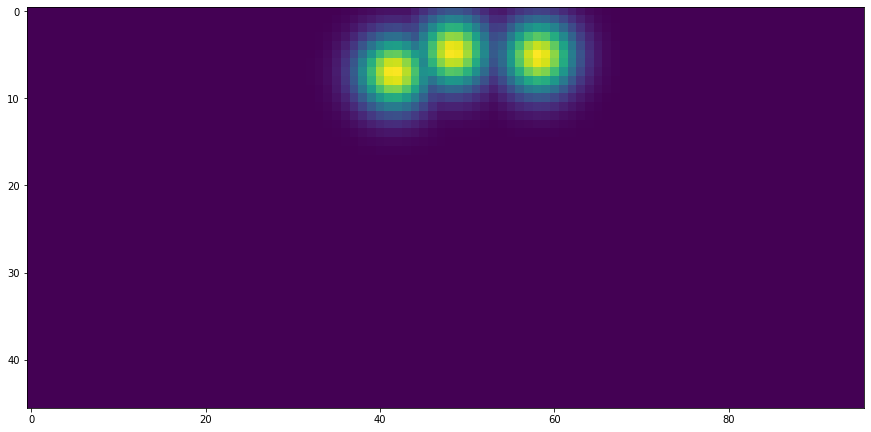

In [64]:
pic_idx = 0
#testing img
single_kpt = sample_elem[1][5][pic_idx,...,0]
plt.figure(figsize=[15,15])
plt.imshow(single_kpt)

In [65]:
def find_max(single_kpt):
    idx_max = np.unravel_index(np.argmax(single_kpt), single_kpt.shape)
    value = single_kpt[idx_max]
    mask = np.zeros_like(single_kpt)
    mask[idx_max] = 52.84
    mask_gaussian = cv2.GaussianBlur(mask, (0,0) , sigmaX = 2.9, sigmaY = 2.9)
    masked_single_kpt = single_kpt - mask_gaussian
    plt.figure(figsize=[15,15])
    plt.imshow(mask_gaussian)

    return idx_max, value, masked_single_kpt

In [62]:
def find_max_distance(single_kpt):
    idx_max = np.unravel_index(np.argmax(single_kpt), single_kpt.shape)  
    value = single_kpt[idx_max]
    dim0, dim1 = single_kpt.shape
    y_grid = np.linspace(0, dim0, num=dim0)
    x_grid = np.linspace(0, dim1, num=dim1)
    yy, xx = np.meshgrid(y_grid, x_grid, indexing='ij')
    grid = np.stack((yy, xx), axis=-1)
    
    dist = (grid - idx_max) / [dim0, dim0]
    norm = np.linalg.norm(dist, axis=-1)
    mask = np.exp(-norm**2/0.008)
    
    mask[mask<=0.001] = 0
    plt.figure(figsize=[15,15])
    plt.imshow(mask)
    masked_single_kpt = single_kpt - mask
    
    return idx_max, value, masked_single_kpt

idx_max: (3, 48)
value: tf.Tensor(0.016673828, shape=(), dtype=float32)


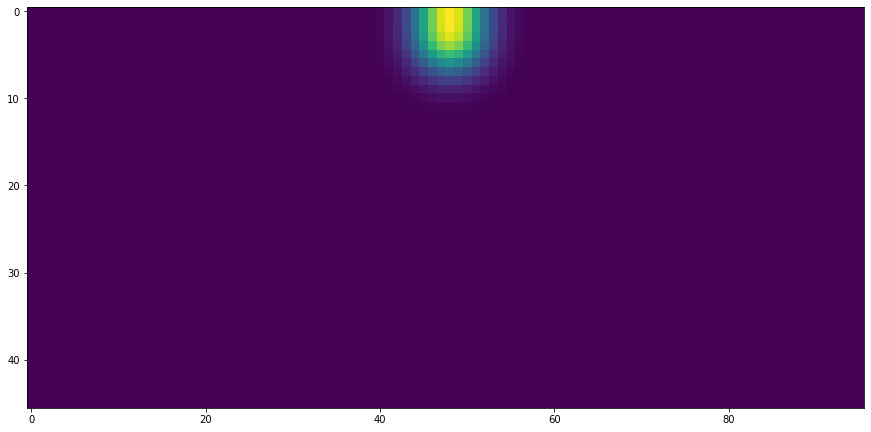

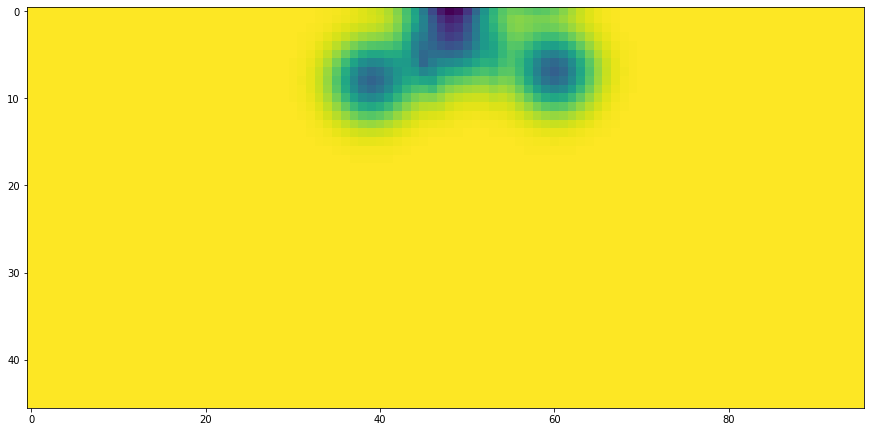

In [71]:
idx_max, value, single_kpt = find_max(single_kpt)
plt.figure(figsize=[15,15])
plt.imshow(single_kpt)
print("idx_max:", idx_max)
print("value:", value)

# Test of model outputs

In [16]:
kpts = np.load('kpts.npy')
pafs = np.load('pafs.npy')
img = np.load('img.npy')
single_kpt = kpts[0,...,0]

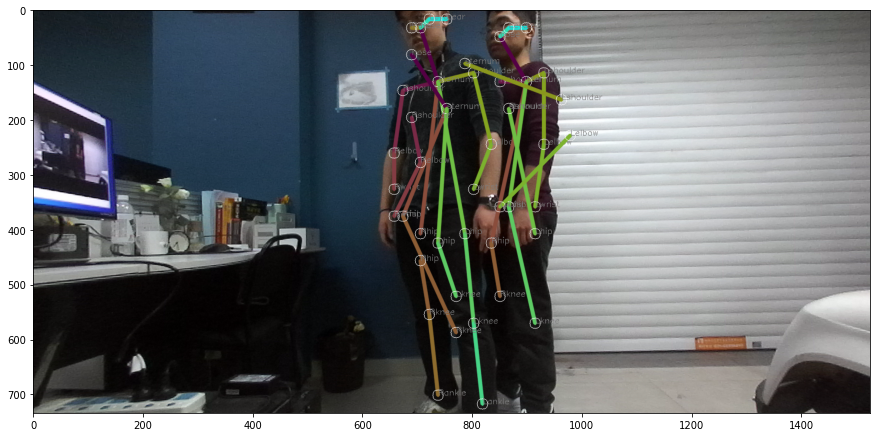

In [17]:
plt.figure(figsize=[15,15])
plt.imshow(img)

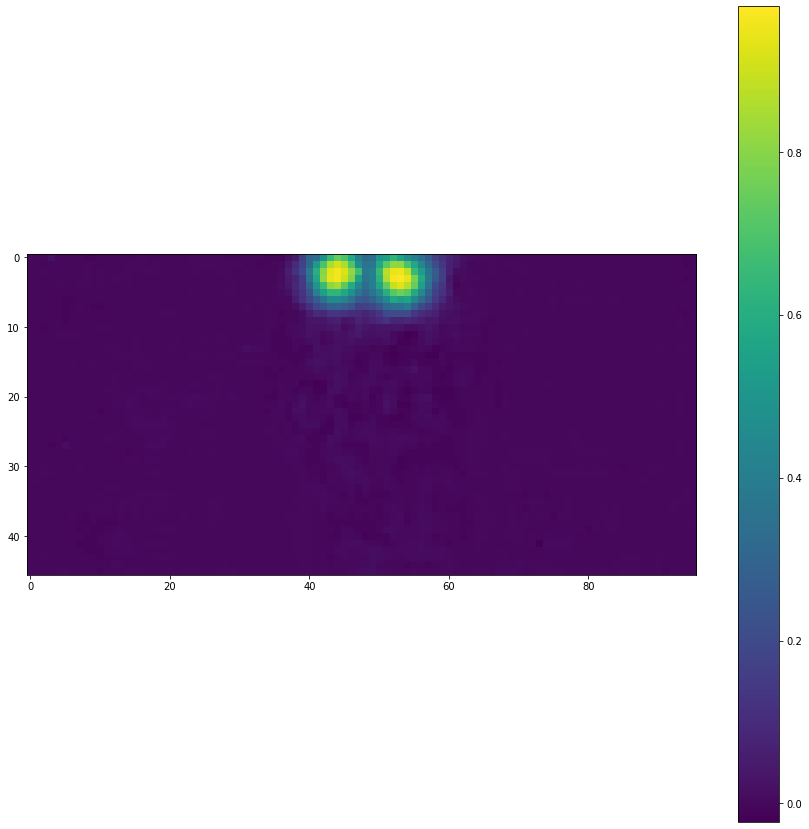

In [18]:
plt.figure(figsize=[15,15])
plt.imshow(single_kpt)
plt.colorbar()

idx_max: (2, 58)
value: 0.1229207793556216


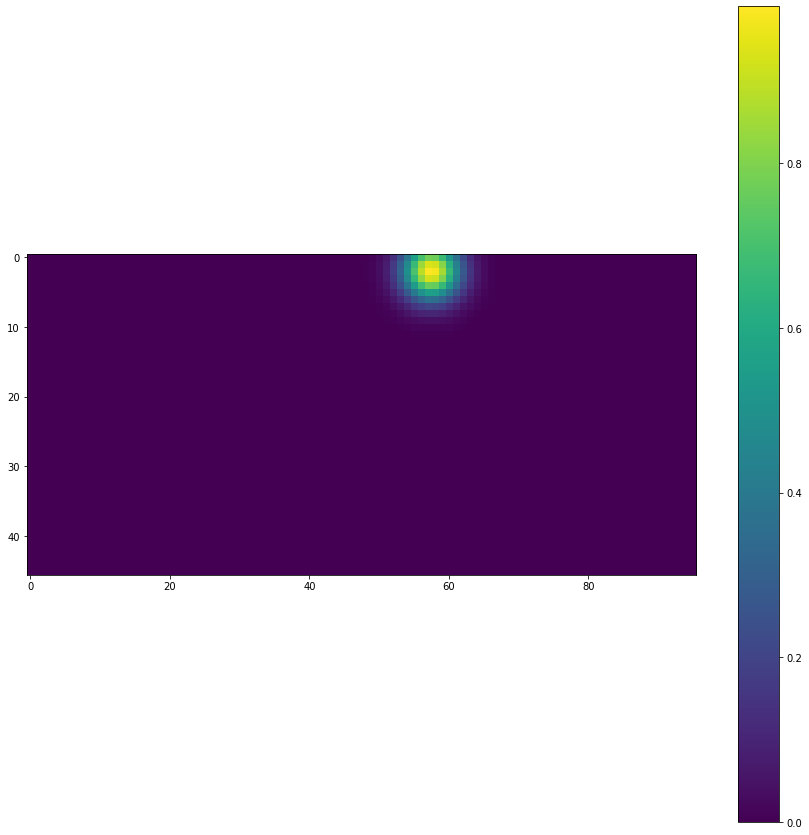

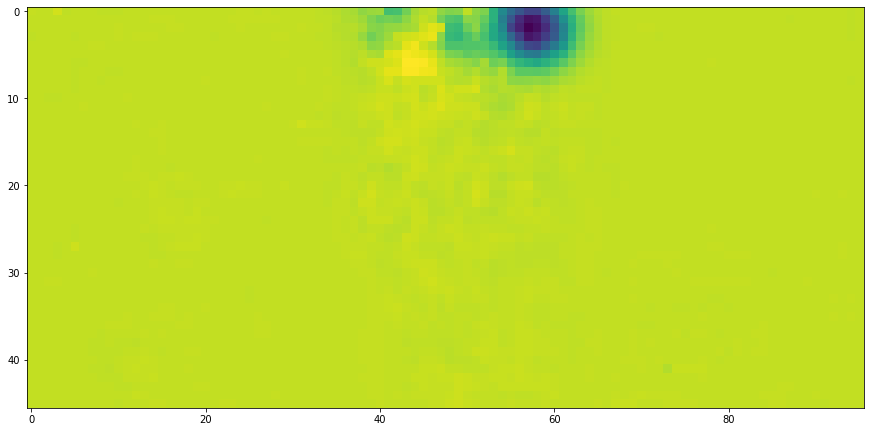

In [15]:
idx_max, value, single_kpt = find_max_distance(single_kpt)
plt.figure(figsize=[15,15])
plt.imshow(single_kpt)
print("idx_max:", idx_max)
print("value:", value)